# Import traffic collison data from 2016

In [2]:
%load_ext rpy2.ipython

In [3]:
import pandas as pd
import numpy as np
import os
import glob

In [4]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [5]:
filename=pd.read_csv('fars_2016_36.csv')

/Users/linmeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
filename.rename(columns = {'istatenum':'statenum', "icasenum": "casenum", 
                           'icity':'city', 'saccdate': 'accdate','ialcinvol':'malcohol',
                          'acctime':'sacctime'}, inplace = True)

# generate definitions for time of day

In [7]:
filename['sacctime']=pd.to_numeric(filename['sacctime'],errors='coerce')
filename['sacctime']=filename['sacctime'].fillna(0).astype(int)
filename.loc[((filename['sacctime']>=600)&(filename['sacctime']<=1000)),'time_period']='morning_rush'
filename.loc[((filename['sacctime']>1000)&(filename['sacctime']<1400)),'time_period']='mid-day'
filename.loc[((filename['sacctime']>1400)&(filename['sacctime']<1600)),'time_period']='afternoon'
filename.loc[((filename['sacctime']>=1600)&(filename['sacctime']<=2000)),'time_period']='evening_rush'
filename.loc[(filename['sacctime']>2000),'time_period']='evening'
filename.loc[(filename['sacctime']<600),'time_period']='morning'

In [8]:
filename['weekday']='workday'
filename['dayofweek']=pd.to_numeric(filename['dayofweek'],errors='coerce')
filename.loc[(filename['dayofweek']==7)|(filename['dayofweek']==1),'weekday']='weekend'

# import TNC data

In [11]:
tnc=pd.read_csv('trip_stats_taz_0.csv')
tnc.head()

,taz,day_of_week,hour,pickups,dropoffs,total
0,1,0,3,0.6,0.4,1000
1,1,0,4,0.0,0.4,400
2,1,0,5,0.6,0.6,1200
3,1,0,6,0.8,1.0,1800
4,1,0,7,0.6,0.8,1400


# aggregate TNC data by time of week

In [12]:
f=filename.groupby(['time_period','weekday']).agg({'casenum':'count'}).reset_index()

In [13]:
f.head()

,time_period,weekday,casenum
0,afternoon,weekend,2627
1,afternoon,workday,5957
2,evening,weekend,4938
3,evening,workday,9855
4,evening_rush,weekend,5888


# Clean up TNC data

In [38]:
trip=pd.read_csv('trip_stats_taz_0.csv')
trip['hour']=trip['hour'].astype(str)
trip['hour']=trip['hour'].apply(lambda x: x.replace('25','1'))
trip['hour']=trip['hour'].apply(lambda x: x.replace('26','2'))
trip['hour']=trip['hour'].astype(int)
trip=trip.sort_values(by=['hour'])

create logistic for time period during the day (from common sense)

In [39]:
trip.loc[((trip['hour']>=6)&(trip['hour']<=10)),'time_period']='morning_rush'
trip.loc[((trip['hour']>10)&(trip['hour']<14)),'time_period']='mid-day'
trip.loc[((trip['hour']>14)&(trip['hour']<16)),'time_period']='afternoon'
trip.loc[((trip['hour']>=16)&(trip['hour']<=20)),'time_period']='evening_rush'
trip.loc[(trip['hour']>20),'time_period']='evening'
trip.loc[(trip['hour']<6),'time_period']='morning'

# create same logistic for time priod in TNC data

In [292]:
morning_rush_per=(trip.loc[trip['time_period']=='morning_rush'].count()/trip.shape[0])[0]
midday_per=(trip.loc[trip['time_period']=='mid-day'].count()/trip.shape[0])[0]
afternoon_per=(trip.loc[trip['time_period']=='afternoon'].count()/trip.shape[0])[0]
evening_rush_per=(trip.loc[trip['time_period']=='evening_rush'].count()/trip.shape[0])[0]
evening_per=(trip.loc[trip['time_period']=='evening'].count()/trip.shape[0])[0]
morning_per=(trip.loc[trip['time_period']=='morning'].count()/trip.shape[0])[0]
per=[afternoon_per,evening_per,evening_rush_per,midday_per,morning_per,morning_rush_per]

# Create day of week trend for San Francisco 

# workday

In [25]:
trip['total']=trip['pickups']+trip['dropoffs']  # add up the total trip for TNC data
trip.head()

,taz,day_of_week,hour,pickups,dropoffs,total,time_period
54934,327,6,1,11.25,9.00,20.25,morning
62182,371,0,1,2.20,2.80,5.00,morning
119734,713,4,1,49.25,31.75,81.00,morning
62158,370,6,1,0.75,3.00,3.75,morning
6142,37,3,1,1.00,1.75,2.75,morning


In [157]:
trip['weekday']='workday'
trip_a.loc[(trip['day_of_week']==6)|(trip['day_of_week']==5),'weekday']='weekend'
trip_a=trip_a.loc[trip['weekday']=='workday']
trip_agg=trip_a.groupby(['time_period','weekday'])
trip_a=trip_agg['total'].sum().add_prefix("").reset_index()
total_sum=trip_a.total.sum()
trip_a['per']=trip_a['total']/total_sum
trip_a=trip_a.loc[trip_a.time_period!='morning']

In [190]:
sanf=filename[(filename.statenum==6)&(filename.city == 3290)|(filename.city == 1980)|(filename.city == 3340)]
tot=sanf.shape[0]
tot

998

# calculate the percentage of traffic collison by day of week

In [192]:
sanf=filename[(filename.statenum==6)&(filename.city == 3290)|(filename.city == 1980)|(filename.city == 3340)]
wmorning_rush_per=((sanf.loc[(sanf['time_period']=='morning_rush')&(sanf['weekday']=='workday')].count())/tot)[0]
wmidday_per=((sanf.loc[(sanf['time_period']=='mid-day')&(sanf['weekday']=='workday')].count())/tot)[0]
wafternoon_per=((sanf.loc[(sanf['time_period']=='afternoon')&(sanf['weekday']=='workday')].count())/tot)[0]
wevening_rush_per=((sanf.loc[(sanf['time_period']=='evening_rush')&(sanf['weekday']=='workday')].count())/tot)[0]
wevening_per=((sanf.loc[(sanf['time_period']=='evening')&(sanf['weekday']=='workday')].count())/tot)[0]
wmorning_per=((sanf.loc[(sanf['time_period']=='morning')&(sanf['weekday']=='workday')].count())/tot)[0]


In [193]:
sanf_work=sanf.groupby('time_period').agg({'casenum':'count'}).reset_index()

In [194]:
per=[wafternoon_per,wevening_per,wevening_rush_per,wmidday_per,wmorning_per,wmorning_rush_per]
sanf_work['per']=per
sanf_work['color']=0
sanf_work.loc[sanf_work['time_period']=='morning_rush','color']=1
sanf_work.loc[sanf_work['time_period']=='evening_rush','color']=1

In [195]:
sanf_work.color=sanf_work.color.astype(str)
sanf_work=sanf_work.loc[sanf_work.time_period!='morning']

In [196]:
labels=['Morning Rush','Mid Day','Afternoon','Evening Rush','Evening']

In [197]:
%R -i trip_a -i labels -i sanf_work

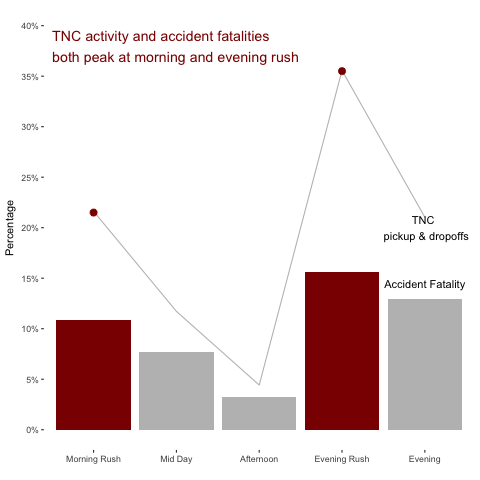

In [293]:
%%R 
ggplot()+
geom_bar(data=sanf_work,
         aes(x=factor(time_period,levels=c('morning_rush','mid-day','afternoon',
                                           'evening_rush','evening')),y=per,fill=color),
     stat = "identity")+
geom_line(data=trip_a,aes(x=time_period,y=per,group=1),color='grey')+
geom_point(aes(x='evening_rush',y=0.355),color='darkred',size=3)+
geom_point(aes(x='morning_rush',y=0.215),color='darkred',size=3)+
scale_fill_manual(values = c('grey','darkred'))+
scale_y_continuous(limits = c(0, 0.4), labels = scales::percent, breaks = seq(0,0.4, by = .05))+
theme(panel.background = element_blank(),legend.position = "none")+xlab('')+ylab('Percentage')+
scale_x_discrete(labels=labels)+
geom_text(aes(x='evening',y=0.2,label='TNC \n pickup & dropoffs'),color='black',position = position_nudge(x =0))+
geom_text(aes(x='evening',y=0.145,label='Accident Fatality'),color='black')+
geom_text(aes(x='morning_rush',y=0.38,
              label='TNC activity and accident fatalities \nboth peak at morning and evening rush'),
          color='darkred',hjust =0,position = position_nudge(x = -0.5),size=5)

# weekend  trend

create percentage for TNC data

In [43]:
trip['weekday']='workday'
#filename['dayofweek']=pd.to_numeric(filename['dayofweek'],errors='coerce')
trip.loc[(trip['day_of_week']==6)|(trip['day_of_week']==5),'weekday']='weekend'
wtrip=trip.loc[trip['weekday']=='weekend']
wtrip_agg=wtrip.groupby(['time_period','weekday'])
wtrip_a=wtrip_agg['total'].sum().add_prefix("").reset_index()
wtotal_sum=wtrip_a.total.sum()
wtrip_a['per']=wtrip_a['total']/wtotal_sum
wtrip_a

,time_period,weekday,total,per
0,afternoon,weekend,36438500,0.054856
1,evening,weekend,154409500,0.232456
2,evening_rush,weekend,231267500,0.348163
3,mid-day,weekend,99333500,0.149542
4,morning,weekend,61153500,0.092064
5,morning_rush,weekend,81649000,0.122919


# select major cities in California: San Francisco, San Jose, Los Angeles

In [202]:
sanf=filename[(filename.statenum==6)&(filename.city == 3290)|(filename.city == 1980)|(filename.city == 3340)&(filename.malcohol != 1)]

calculate the percentage of fatalities by day of week

In [204]:
sanf=filename[(filename.malcohol!= 1)&(filename.statenum==6)&(filename.city == 3290)|(filename.city == 1980)|
              (filename.city == 3340)]
morning_rush_per=((sanf.loc[(sanf['time_period']=='morning_rush')&(sanf['weekday']=='weekend')].count())/tot)[0]
midday_per=((sanf.loc[(sanf['time_period']=='mid-day')&(sanf['weekday']=='weekend')].count())/tot)[0]
afternoon_per=((sanf.loc[(sanf['time_period']=='afternoon')&(sanf['weekday']=='weekend')].count())/tot)[0]
evening_rush_per=((sanf.loc[(sanf['time_period']=='evening_rush')&(sanf['weekday']=='weekend')].count())/tot)[0]
evening_per=((sanf.loc[(sanf['time_period']=='evening')&(sanf['weekday']=='weekend')].count())/tot)[0]
morning_per=((sanf.loc[(sanf['time_period']=='morning')&(sanf['weekday']=='weekend')].count())/tot)[0]
san_per=[afternoon_per,evening_per,evening_rush_per,midday_per,morning_per,morning_rush_per]
san_per

[0.013457556935817806,
 0.08385093167701864,
 0.08178053830227744,
 0.061076604554865424,
 0.13664596273291926,
 0.021739130434782608]

aggregate data by time period and day of week

In [205]:
san=sanf.groupby(['time_period','weekday']).agg({'casenum':'count'}).reset_index()

In [206]:
san['color']=0
san.loc[san['time_period']=='morning','color']=0
san.loc[san['time_period']=='evening_rush','color']=1
san.loc[san['time_period']=='mid-day','color']=1

In [207]:
san=san[san['weekday']=='weekend']
san

,time_period,weekday,casenum,color
0,afternoon,weekend,13,0
2,evening,weekend,81,0
4,evening_rush,weekend,79,1
6,mid-day,weekend,59,1
8,morning,weekend,132,0
10,morning_rush,weekend,21,0


In [208]:
san.color=san.color.astype(str) 

clean up the data by getting rid of outliers

In [209]:
wtrip_a=wtrip_a.loc[wtrip_a.time_period!='morning']
san['percent']=san_per
san=san.loc[san.time_period!='morning']

In [ ]:
labels=['Morning Rush','Mid Day','Afternoon','Evening Rush','Evening']

In [211]:
%R -i san -i wtrip_a -i labels

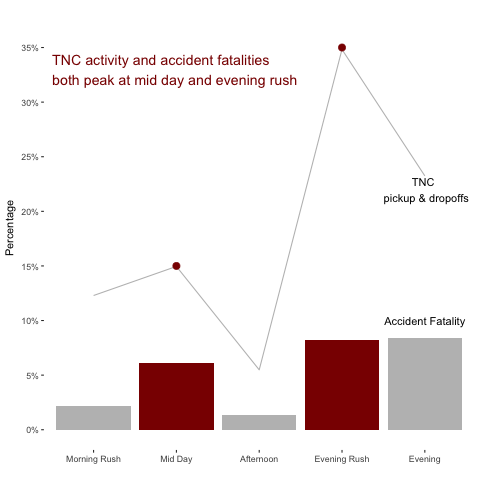

In [294]:
%%R 
ggplot()+geom_bar(data=san,aes(x=factor(time_period,
                                        levels=c('morning_rush','mid-day','afternoon','evening_rush','evening')),
                               y=percent,fill=color),stat = "identity")+
scale_fill_manual(values = c('grey','darkred'))+
geom_line(data=wtrip_a,aes(x=time_period,y=per,group=1),color='grey')+
geom_point(aes(x='evening_rush',y=0.35),color='darkred',size=3)+
geom_point(aes(x='mid-day',y=0.15),color='darkred',size=3)+
theme(panel.background = element_blank(),legend.position = "none")+xlab('')+ylab('Percentage')+
scale_x_discrete(labels=labels)+
scale_y_continuous(limits = c(0, 0.37), labels = scales::percent, breaks = seq(0,0.37, by = .05))+
geom_text(aes(x='evening',y=0.22,label='TNC \n pickup & dropoffs'),color='black',position = position_nudge(x =0))+
geom_text(aes(x='evening',y=0.1,label='Accident Fatality'),color='black')+
geom_text(aes(x='morning_rush',y=0.33,
              label='TNC activity and accident fatalities \nboth peak at mid day and evening rush'),
          color='darkred',hjust=0,position = position_nudge(x = -0.5),size=5)


# word cloud

# compare the distraction word frequency by looking at 2010 and 2016 distraction words

inspect data

In [296]:
distract=pd.read_csv('word_cloud.csv')
distract.head()

,dridistract,Reason
0,1,Looked But Did Not See
1,3,By Other Occupant(s)
2,4,By A Moving Object In Vehicle
3,5,Cellular Phone
4,6,Cellular Phone


In [263]:
word=pd.read_csv('fars_2010_36.csv')

/Users/linmeng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


clean up the word document

In [264]:
word['dridistract']=pd.to_numeric(word['dridistract'],errors='coerce')
word['dridistract']=word['dridistract'].fillna(0)
word['dridistract']=word['dridistract'].astype(int)

In [265]:
df=pd.merge(word,distract,how='left',on='dridistract') #merge the word document with traffic collision data
df=df.dropna()

In [266]:
df['Reason']=df['Reason'].apply(lambda x: x.replace(' ','_'))  #clean up the word document so it shows up sentences 
df=df[df['Reason']!='Distraction_']

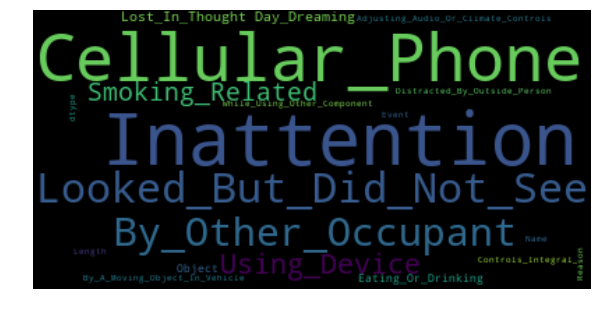

In [268]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
text = str(df['Reason'])
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.gcf().set_size_inches(10,10)
plt.axis("off")
#plt.show()
plt.savefig('a.png')

# inspect the same thing but for year=2016

In [269]:
word=pd.read_csv('fars_2016_36.csv')

In [270]:
word['dridistract']=pd.to_numeric(word['dridistract'],errors='coerce')
word['dridistract']=word['dridistract'].fillna(0)
word['dridistract']=word['dridistract'].astype(int)

In [271]:
df=pd.merge(word,distract,how='left',on='dridistract')
df=df.dropna()

In [272]:
df['Reason']=df['Reason'].apply(lambda x: x.replace(' ','_'))
df=df[df['Reason']!='Distraction_']

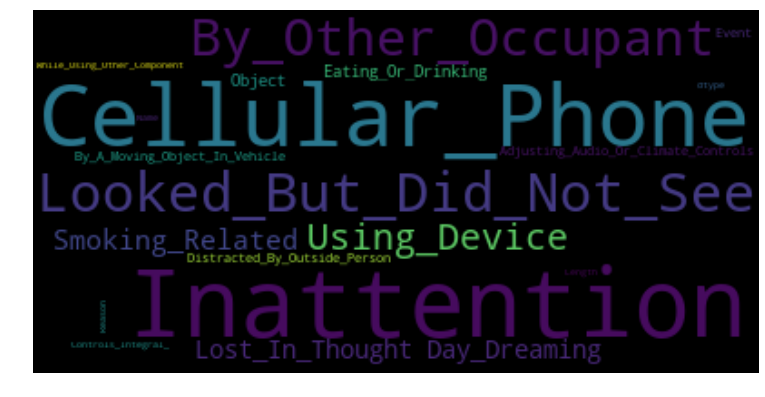

In [277]:
text = str(df['Reason'])
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.gcf().set_size_inches(13,10)
plt.axis("off")
plt.savefig('b.png')